# Time of Emergence of the Global Mean

This version differs from the previous version as it is constucted from draft_03_v2 which uses version that have been shifted to functions and standardised.

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import climate_utils
import plotting_utils
import stats
import time_of_emergence_plots
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/116341073.gadi-pbs/matplotlib-mbxf40em because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:

import matplotlib.pylab as pylab
params = {'axes.labelsize' : 'xx-large', 'legend.fontsize': 'xx-large', 
          'xtick.labelsize': 'xx-large', 'ytick.labelsize': 'xx-large'}
            
pylab.rcParams.update(params)

In [3]:
# from dask.distributed import Client
# client = Client()
# client

In [4]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [5]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [6]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

In [7]:
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)

In [8]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [9]:
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [10]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [11]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()>
-0.2854

In [12]:
# Resetting the anomlies to 1850
best_ds_smean = best_ds_smean - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

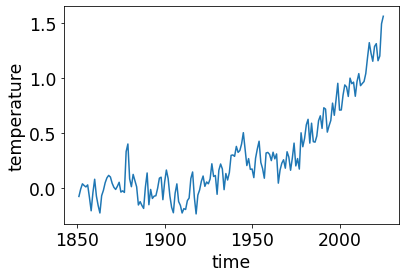

In [13]:
best_ds_smean.plot()

# Calculations

In [14]:
window = 20

## Signal-to-Noise

In [15]:
# As these are anomalies, the signal is just going to be the
ds_best_smooth = stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=40)#method='POLYNOMIAL', order=4)#

In [16]:
# noise_ds = base_period_ds.std(dim='time').to_numpy()
# noise_ds

In [17]:
noise_ds = (best_ds_smean-ds_best_smooth).std().to_numpy()
noise_ds

array(0.1074517)

In [18]:
# I know that the temperature is already an anomly, but it cleary wasn't in 
# reference to my base period. This should just translate the data updwardss,
# increasing the signal, so that the baser period is now centered on zero.

ds_best_smooth_signal = ds_best_smooth#- base_period_ds_average

In [19]:
ds_best_sn = ds_best_smooth_signal/noise_ds
ds_best_sn

<xarray.DataArray 'temperature' (time: 175)>
-0.3559 -0.3334 -0.3106 -0.2872 -0.2635 ... 11.73 11.96 12.18 12.41 12.64
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [20]:
ds_best_sn.attrs = {'longname': 'Signal-to-Noise Ratio'}

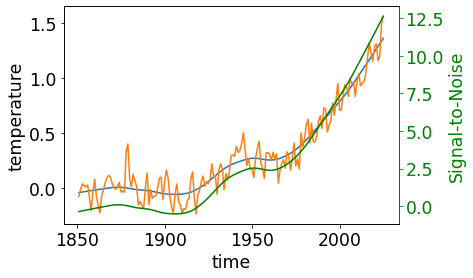

In [21]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_smooth.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

In [22]:
import matplotlib.ticker as mticker

In [23]:
np.arange(-0.25, 0.25*8, 0.25)

array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75])

In [24]:
ax.get_xticklabels()

[Text(-73048, 0, '1800'),
 Text(-54786, 0, '1850'),
 Text(-36524, 0, '1900'),
 Text(-18262, 0, '1950'),
 Text(0, 0, '2000'),
 Text(18263, 0, '2050')]

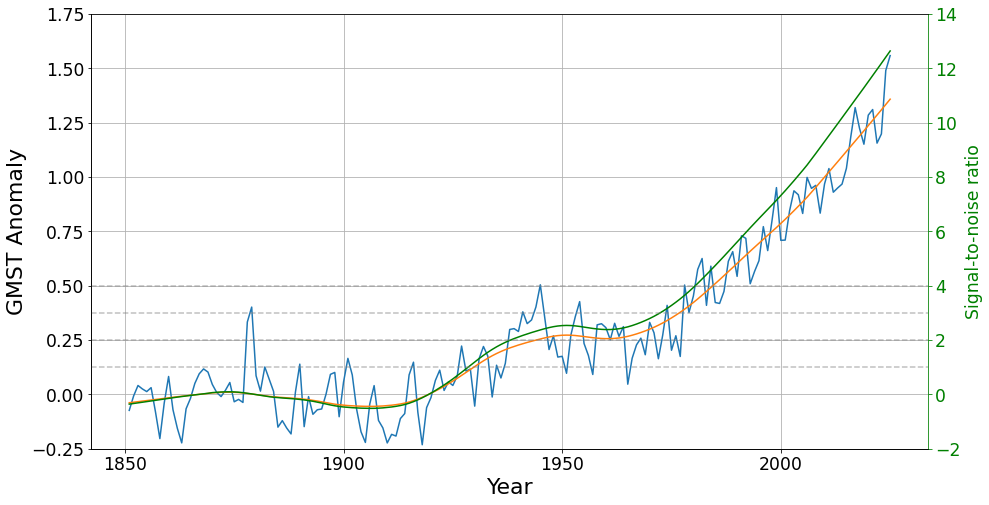

In [200]:
fig, ax = plt.subplots(figsize=(15, 8))
best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)

ax_twinx = ax.twinx()


ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax1 = ax
ax2 = ax_twinx
ax2.set_ylim(-2,14)
ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 9))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 9))

ax.grid(True)


In [290]:
best_ds_smean.time[best_ds_smean.time.dt.year == 1929].values

array([cftime.DatetimeGregorian(1929, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

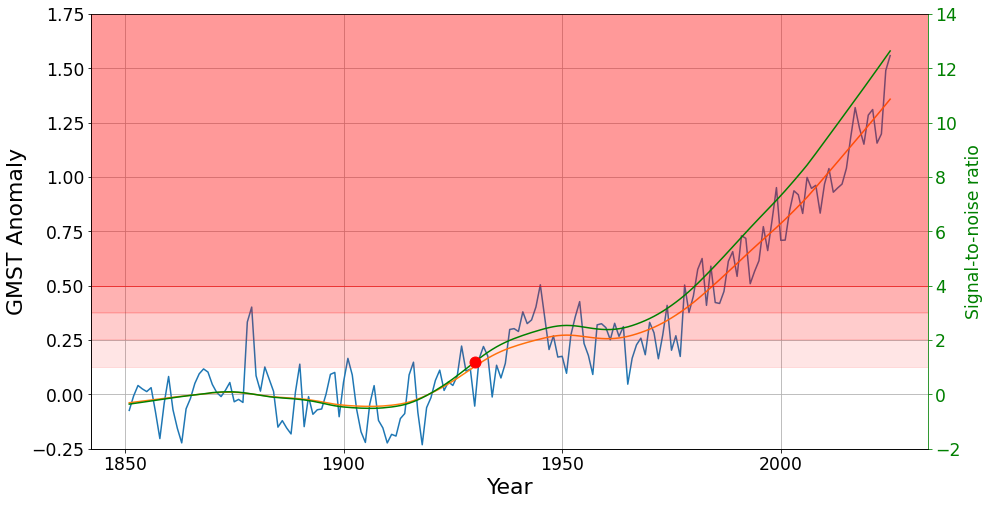

In [300]:
fig, ax = plt.subplots(figsize=(15, 8))
best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)

ax_twinx = ax.twinx()


ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax1 = ax
ax2 = ax_twinx
ax2.set_ylim(-2,14)
ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 9))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 9))


ax2.axhspan(1, 2, color='red', alpha=0.1)
ax2.axhspan(2.05, 3, color='red', alpha=0.2)
ax2.axhspan(3.05, 4, color='red', alpha=0.3)
ax2.axhspan(4., 14, color='red', alpha=0.4)

ax.grid(True)

ax2.scatter(ds_best_sn.time[ds_best_sn.time.dt.year == 1929].values[0], ds_best_sn[ds_best_sn.time.dt.year == 1929].values[0], 
           s=120, color='red', zorder=1000)

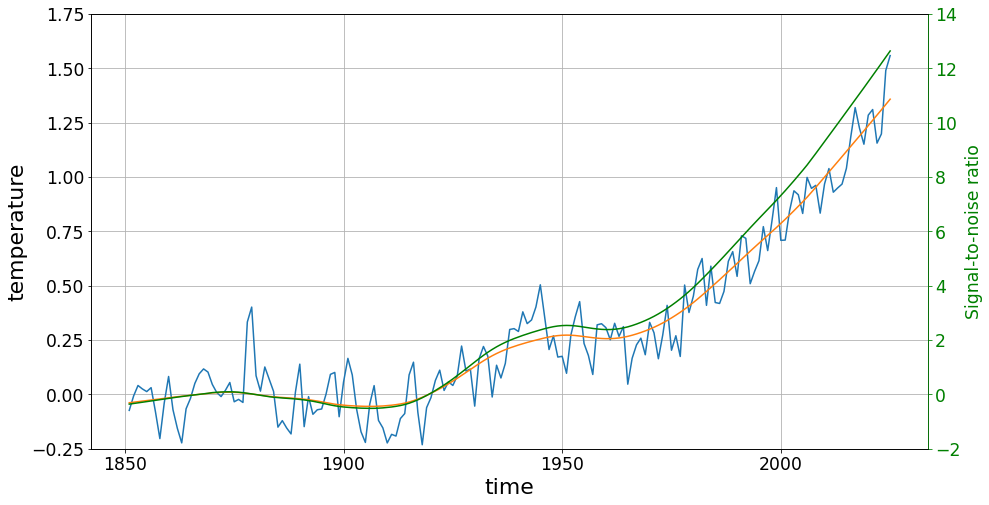

In [261]:
fig, ax = plt.subplots(figsize=(15, 8))
ax_twinx = ax.twinx()


# Define the rectangular patches on the secondary y-axis
xstart = ax_twinx.get_xbound()[0]
width = np.sum(np.abs(ax_twinx.get_xbound()))

rect1 = patches.Rectangle((xstart, -2), width, 3, edgecolor=None, alpha=0.4, facecolor='grey', zorder=1)
rect2 = patches.Rectangle((xstart, 1), width, 1, edgecolor=None, alpha=0.6, facecolor='grey', zorder=1)
rect3 = patches.Rectangle((xstart, 2), width, 1, edgecolor=None, alpha=0.8, facecolor='grey', zorder=1)
rect4 = patches.Rectangle((xstart, 3), width, 1, edgecolor=None, alpha=1, facecolor='grey', zorder=1)

# Add patches to the secondary y-axis
ax_twinx.add_patch(rect1)
ax_twinx.add_patch(rect2)
ax_twinx.add_patch(rect3)
ax_twinx.add_patch(rect4)

# Plot on the secondary y-axis
ds_best_sn.plot(ax=ax_twinx, color='green', zorder=2)  # Ensure the plot is in front

# Labels and grid
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', colors='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax_twinx.set_ylim(-2, 14)
ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 9))
ax_twinx.set_yticks(np.linspace(ax_twinx.get_ybound()[0], ax_twinx.get_ybound()[1], 9))


# Plot on the primary y-axis
best_ds_smean.plot(ax=ax, zorder=3)  # Ensure these plots are in front
ds_best_smooth.plot(ax=ax, zorder=3)  # Ensure these plots are in front

ax.grid(True)

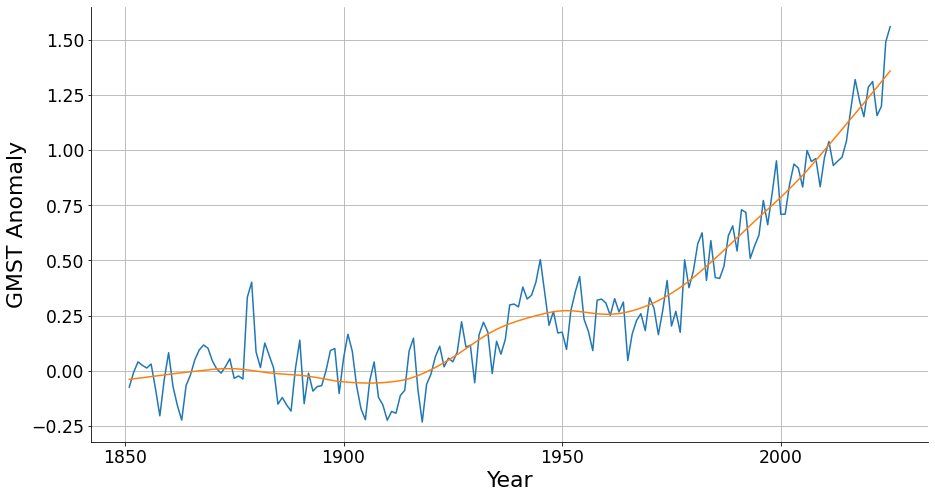

In [101]:
fig, ax = plt.subplots(figsize=(15, 8))
best_ds_smean.plot(ax=ax)
ds_best_smooth.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax.grid(True)

## p-value tests

In [74]:
reload(toe)

<module 'time_of_emrgence_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py'>

In [22]:
from scipy.stats import anderson_ksamp

In [27]:
anderson_ksamp([[1,2,3,4,6], [1,2,3,46,6]]).significance_level

0.25

In [28]:
reload(toe)

<module 'time_of_emrgence_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py'>

In [29]:
# This version is better
ks_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ks_pvalue)
ttest_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ttest_pvalue)
anderson_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_anderson_pvalue)

In [30]:
ks_ds

<xarray.DataArray 'temperature' (time: 155)>
0.9999 0.9999 0.9999 0.9999 0.9999 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 1860-12-31 00:00:00 ... 2014-12-31 00:00:00

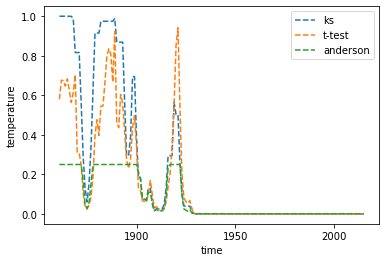

In [31]:
ks_ds.plot(label='ks', linestyle='--')
ttest_ds.plot(label='t-test', linestyle='--')
anderson_ds.plot(label='anderson', linestyle='--')

plt.legend()

# Getting ToE

In [32]:
PVALUE_THESHOLD1 = 0.01

In [33]:
ds_best_sn.name = 'signal_to_noise'
ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
anderson_ds.name = 'anderson'

In [34]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal to Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'

In [35]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn]).dropna(dim='time')

In [282]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=1, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds])

In [283]:
toe_ds

<xarray.Dataset>
Dimensions:          ()
Data variables:
    signal_to_noise  float64 1.929e+03
    ks               float64 1.928e+03
    ttest            float64 1.928e+03
    anderson         float64 1.927e+03
Attributes: (2)

# Plotting

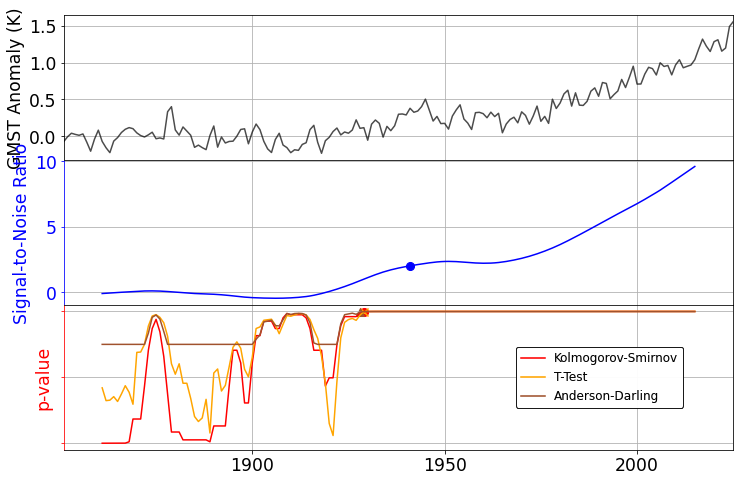

In [105]:
time_of_emergence_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds,
    toe_ds,
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'}
    )


In [40]:
central_year  = 1883
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-10, central_year+11)))

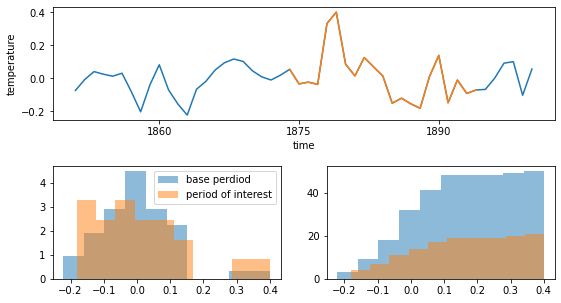

In [41]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);